### Imports

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras.layers import Input, Dense
from training.datasets import load_dataset
from models.gpu.layers import Normalizer
from models.gpu.metrics import MaxAbsoluteError, MeanAbsoluteMassLoss, cut_labels
from training.utils import CustomTensorboard, manual_scheduler
from models.analytical import MultiOccupationMultiIsotope
import numpy as np

# Multi-Occupation, Multi Isotope, fixed matrix, normalized

In [33]:
info, (train_x,train_y),(val_x,val_y) = load_dataset("Multi-Occupation, Multi Isotope, fixed matrix, normalized")

In [48]:
model = keras.Sequential(
    [
        Input(shape= (info["input_channels"],)),
        Dense(256,activation="relu"),
        Dense(256,activation="relu"),
        Dense(256,activation="relu"),
        Dense(info["output_channels"], activation="leaky_relu"),
        Normalizer(norm_loss_weight=0.1)
    ]
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12)             │         3,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalizer_2 (Normalizer)       │ (None, 12)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,252 (540.05 KB)

 Trainable params: 138,252 (540.05 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-3),
    loss = "mse",
    metrics = [
        MaxAbsoluteError(),
        # MeanAbsoluteMassLoss(),
        "mae"
    ]
    )

In [50]:
model.fit(
    train_x,
    train_y,
    validation_data = (val_x, val_y),
    batch_size=2**12,
    epochs=60,
    shuffle = True,
    callbacks = [
        CustomTensorboard("logs/momi_fixed_normalized"),
        keras.callbacks.LearningRateScheduler(manual_scheduler),
    ],
)

Epoch 1/60
232/232 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0173 - mae: 0.0540 - max_ae: 0.8830 - val_loss: 0.0079 - val_mae: 0.0391 - val_max_ae: 0.3479 - learning_rate: 0.0030
Epoch 2/60
232/232 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0038 - mae: 0.0262 - max_ae: 0.3574 - val_loss: 0.0064 - val_mae: 0.0329 - val_max_ae: 0.3220 - learning_rate: 0.0030
Epoch 3/60
232/232 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0030 - mae: 0.0195 - max_ae: 0.2858 - val_loss: 0.0046 - val_mae: 0.0295 - val_max_ae: 0.2729 - learning_rate: 0.0030
Epoch 4/60
232/232 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0018 - mae: 0.0155 - max_ae: 0.2630 - val_loss: 0.0040 - val_mae: 0.0277 - val_max_ae: 0.2337 - learning_rate: 0.0030
Epoch 5/60
232/232 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0015 - mae: 0.0125 - max_ae: 0.2378 - val_loss: 0.0035 - val_mae: 0.0253 - val_max_ae: 0.2117 - learning_rate: 0.0030
Epoch 6/60
232/232 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0013 - mae: 0.0104 - max_ae: 0

KeyboardInterrupt: 

In [43]:
predictions = model.predict(val_x, batch_size=2**12)
predictions.shape

 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(50000, 12)

In [44]:
indices = np.argsort(np.max(np.abs(predictions - val_y),axis= 1))
worst = indices[-100:]
worst

array([43259, 43260, 43261, 43262, 43291, 43184, 43329, 43330, 43331,
       43228, 43167, 43264, 43153, 43154, 43155, 43156, 43157, 43158,
       43239, 43208, 43225, 43226, 43227, 43279, 43229, 43230, 43247,
       43152, 43297, 43298, 43299, 43300, 43301, 43302, 43255, 43288,
       43219, 43273, 43332, 43274, 43275, 43276, 43277, 43278, 43231,
       43328, 43217, 43320, 43287, 43218, 43220, 43222, 43290, 43333,
       43334, 43289, 43272, 43303, 43221,  5971,   230,  1796, 25263,
        5968, 11609,  1795,  5970, 11618,  5969,  1794,  1786, 25262,
        1787,  1788,  1793,  1789,  1792,  1790,  1791, 25261, 25260,
       25259, 11610, 25258, 11617, 25257, 25256, 25255, 25254, 25249,
       25250, 25253, 25251, 25252, 11616, 11611, 11615, 11612, 11613,
       11614])

In [45]:
momi = MultiOccupationMultiIsotope(fixed=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


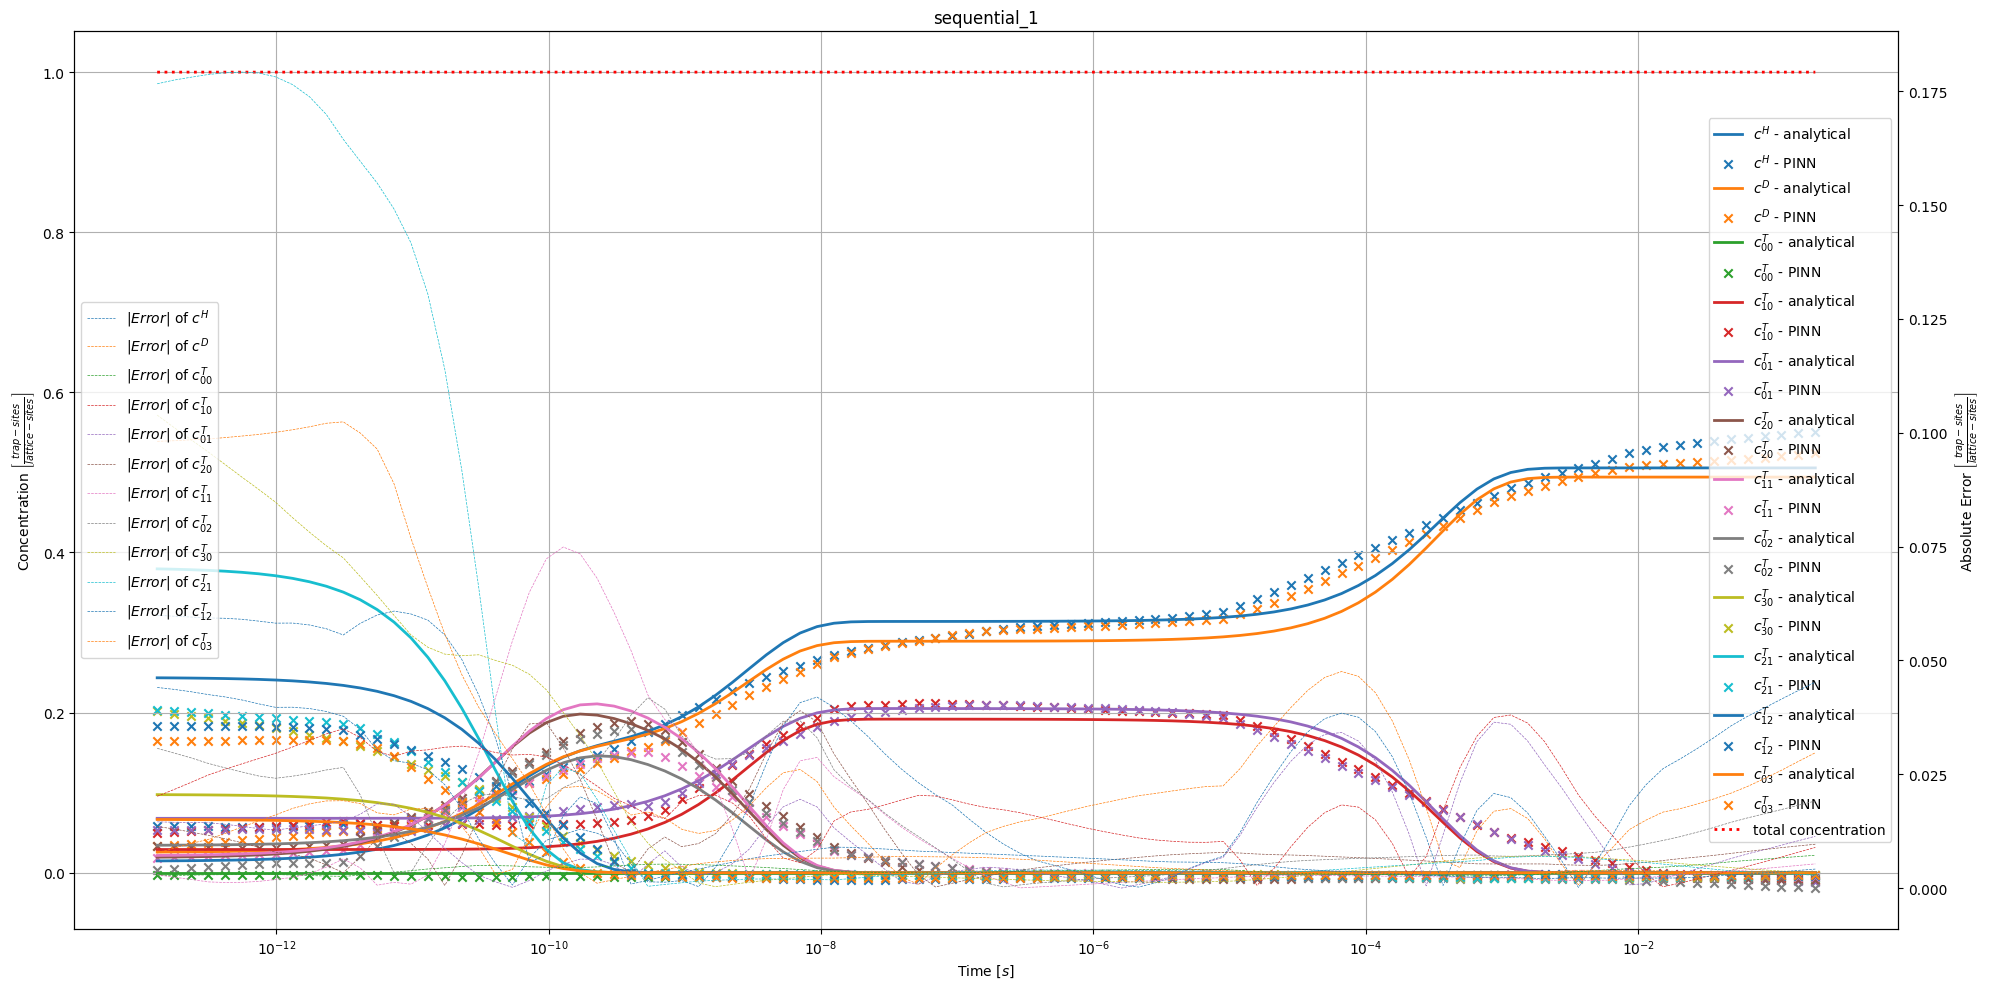

In [47]:
momi.evaluate(model, pre_normalized=True, initial_values=val_x[1791,1:], n_eval=100, log_t_eval=True)